# AWS Event Analysis

In [1]:
#Imports
import numpy as np
import pandas as pd
import json
from collections import defaultdict
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# What does our data look like?

In [12]:
page_ended_path = r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt'
with open(page_ended_path, 'r') as file:
    for i in range(3):
        print(file.readline())
        print()
        
    print("Each Record is a JSON with the structure:")
        
    line = json.loads(file.readline().rstrip())
    print(json.dumps(line, indent=4))

{"event_type": "PageEnded", "event_timestamp": 1518168269399, "arrival_timestamp": 1518168285800, "event_version": "3.0", "application": {"app_id": "4d29e476a66b4a5da830b905c8bc5e80", "cognito_identity_pool_id": "us-east-1:2c0f73f6-f544-4db3-93e3-7df5d4bbe0a5", "package_name": "edu.stanford.MyHeartCounts", "sdk": {"name": "aws-sdk-iOS", "version": "2.3.2"}, "title": "MyHeart", "version_name": "101", "version_code": "2.0.3"}, "client": {"client_id": "B6A8386D-D649-4342-9E81-848E8B5EB7B9", "cognito_id": "us-east-1:0d17bc07-9a72-4417-93e4-a857d9bff128"}, "device": {"locale": {"code": "en_GB", "country": "GB", "language": "en"}, "make": "apple", "model": "iPhone", "platform": {"name": "iOS", "version": "11.2.5"}}, "session": {"session_id": "c8bc5e80-8B5EB7B9-20180209-092338376", "start_timestamp": 1518168218377}, "attributes": {"duration": "15", "pageName": "APCActivityTrackingStepViewController", "version": "2.0.3 (101)"}, "metrics": {}}


{"event_type": "PageEnded", "event_timestamp": 15

In [ ]:
#Anna's function to map AWS client IDs to healthcodes, returns dict
def map_aws_to_healthcode(source_table = r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/cardiovascular-AwsClientIdTask-v1.tsv'): 
    client_id_to_health_code_id=dict()
    #read in the data 
    dtype_dict=dict() 
    dtype_dict['names']=('skip',
                         'recordId',
                         'appVersion',
                         'phoneInfo',
                         'uploadDate',
                         'healthCode',
                         'externalId',
                         'dataGroups',
                         'createdOn',
                         'createdOnTimeZone',
                         'userSharingScope',
                         'validationErrors',
                         'AwsClientId')
    dtype_dict['formats']=('S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36')
    try: 
        data=np.genfromtxt(source_table,
                           names=dtype_dict['names'],
                           dtype=dtype_dict['formats'],
                           delimiter='\t',
                           skip_header=True,
                           loose=True,
                           invalid_raise=False)
    except:
        print("failed to load file:"+str(source_table))
        raise Exception() 

    #create a mapping of client id to healthCode 
    for line in data: 
        client_id_to_health_code_id[line['AwsClientId'].decode('UTF-8')] = line['healthCode'].decode('UTF-8')    
    return client_id_to_health_code_id

# Graphing and Analytics Functions

In [6]:
def reject_outliers(data, m=3):
    outliers = data[np.logical_or(abs(data - np.mean(data)) >= m * np.std(data), data <= 2)]
    clean = data[np.logical_and(abs(data - np.mean(data)) < m * np.std(data), data>2)]
    
    num_less = (data <= 2).sum()#(outliers < np.mean(data)).sum()
    num_more = (outliers > np.mean(data)).sum()

    return clean, num_less, num_more

def page_duration():
    '''generates a table and figure describing average time spent on an activity based on activity'''
    
    print("Generating page duration table")
    
    freq = defaultdict(list)
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            dur = int(data["attributes"]["duration"])
            act = data["attributes"]["pageName"]
            
            freq[act].append(dur)
            
    print("Finished loading the data - beginning parsing")
    #Describe all the results
    for key in freq.keys():
        print("Stats for activity {}".format(key))
        print(stats.describe(freq[key]))
        
        #clean up the data a little
        clean, num_less, num_more = reject_outliers(np.array(freq[key]))
        
        #Plot everything
        fig = plt.hist(clean)
        plt.title('Duration spent on activity {} \n {} 2 or less, {} high outliers'.format(key, num_less, num_more))
        plt.xlabel("Duration")
        plt.ylabel("# Occurences")
        plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/duration_{}.png".format(key))
        plt.clf()

In [ ]:
def age_activity(healthcode_map, uniq_only=True):

    '''Generates a figure and table of the average duration spent on various activities depending on age'''
    
    print("Generating age activity table")

    
    age_table = pd.read_csv(r'tables/demographics_summary_v2.age.tsv', delimiter='\t').set_index('Subject')
    
    freq = defaultdict(list)
    uniq = set()
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            act = data["attributes"]["pageName"]
            
            #Include only never before seen ids for each activity
            if(uniq_only):
                if((aws_id, act) in uniq):
                    continue
                else:
                    uniq.add((aws_id, act))
            
            #Get the age
            try:
                healthcode = healthcode_map[aws_id]
                age = int(age_table.loc[healthcode, 'Agex'])
                
                freq[act].append(age)
            except KeyError:
                print("AWS_id not found {}".format(aws_id))
            
    print("Finished loading the data - beginning parsing")
    #Describe all the results
    for key in freq.keys():
        print("Stats for activity {}".format(key))
        print(stats.describe(freq[key]))
        
        
        #Plot everything
        fig = plt.hist(freq[key])
        plt.title('Age spent on activity {}'.format(key))
        plt.xlabel("Age")
        plt.ylabel("# Occurences")
        plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/age_{}.png".format(key))
        plt.clf()

In [ ]:
def usage_graph(healthcode_map):

    '''
    Generates a figure of overall activities per person
    Returns healthcodes of the 10 most active people
    '''
    
    usage = defaultdict(int)
    invalid_aws_id = set()
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            

            #Get the healthcode
            try:
                healthcode = healthcode_map[aws_id] 
                
                #Count usage
                usage[healthcode] += 1
            except KeyError:
                #print("AWS_id not found {}".format(aws_id))
                invalid_aws_id.add(aws_id)
            
    print("There were {} distinct invalid aws ids".format(len(invalid_aws_id)))
    print("Finished loading the data - beginning graphing")
        
    #Plot everything
    fig = plt.hist(list(usage.values()))
    plt.title("Activity of users")
    plt.xlabel("# activities")
    plt.ylabel("# users")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/overall_activity.png")
    
    print("Our 10 most active healthcodes were:")
    most_active = sorted(usage, key=usage.get, reverse=True)[:10]
    for i in range(10):
        print("{} with {} activities".format(most_active[i], usage[most_active[i]]))

    return most_active


In [ ]:
def timeline(filename, dates, names):
    
    '''
    timeline(filename, dates, names)
    Function which saves a figure of a timeline of events
    
    filename - unique string to append
    dates - array of datetine objects of each event
    names - array of labels of events
    '''
    
    import matplotlib.dates as mdates
    from datetime import datetime
    
    print("Saving timeline {}".format(filename))
    
    # Choose some nice levels
    levels = np.tile(np.linspace(-5, 5, num=50),
                     int(np.ceil(len(dates)/50)))[:len(dates)]
    
    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(200, 40))
    ax.set(title="Activity of user {}".format(filename))
    
    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-")
    
    plt.setp(markerline, mec="k", mfc="w", zorder=3)
    
    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))
    
    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, r, va in zip(dates, levels, names, vert):
        ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                    textcoords="offset points", va=va, ha="right")
    
    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    
    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)
    
    ax.margins(y=0.1)
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/user_timeline_{}.png".format(filename))
    plt.close()
    
    #Plot histogram of dates
    df = pd.DataFrame(np.ones(len(dates)), pd.DatetimeIndex(dates, name='dates'))
    fig = df.resample('D').sum().hist()
    plt.title("Activity of user {}".format(filename))
    plt.ylabel("# activities")
    plt.xlabel("Date")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/user_hist_{}.png".format(filename))
    plt.close()

def journey_map(healthcode_map, healthcodes):

    '''
    Looks at the events and behavior of a specific set of healthcodes
    '''
    from datetime import datetime

    events = defaultdict(list)
    times = defaultdict(list)
    invalid_aws_id = set()
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            

            #Get the healthcode
            try:
                healthcode = healthcode_map[aws_id] 
                
                #Store events
                if healthcode in healthcodes:
                    act = data["attributes"]["pageName"]
                    #Convert to seconds instead of milliseconds timestamp
                    time = datetime.fromtimestamp(data["event_timestamp"]/1000)

                    events[healthcode].append(act[3:-14])
                    times[healthcode].append(time)
            except KeyError:
                invalid_aws_id.add(aws_id)
            
    print("There were {} distinct invalid aws ids".format(len(invalid_aws_id)))
    print("Finished loading the data - beginning graphing")
    
    for healthcode in healthcodes:
        timeline(healthcode, dates = times[healthcode], names = events[healthcode])

# Eligibility Analysis

In [10]:
sharing = pd.read_csv("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/sharing_scope.csv").set_index("healthCode")
#Get an itemp like
sharing.loc['cd246034-c5dd-4bb9-9e38-f03c1da1beda', "userSharingScope"]

'SPONSORS_AND_PARTNERS'

In [22]:
# Count how many opt for what
options = sharing.loc[:, "userSharingScope"].unique()
print("Available options were {}".format(options))
print("{} people picked {}".format((sharing.loc[:, "userSharingScope"] == 'SPONSORS_AND_PARTNERS').sum(), 'SPONSORS_AND_PARTNERS'))
print("{} people picked {}".format((sharing.loc[:, "userSharingScope"] == 'ALL_QUALIFIED_RESEARCHERS').sum(), 'ALL_QUALIFIED_RESEARCHERS'))

sponsor_hcs = np.array(sharing[sharing.loc[:, "userSharingScope"] == 'SPONSORS_AND_PARTNERS'].index)
all_hcs = np.array(sharing[sharing.loc[:, "userSharingScope"] == 'ALL_QUALIFIED_RESEARCHERS'].index)

Available options were ['SPONSORS_AND_PARTNERS' 'ALL_QUALIFIED_RESEARCHERS']
1844 people picked SPONSORS_AND_PARTNERS
5335 people picked ALL_QUALIFIED_RESEARCHERS


In [23]:
sponsor_hcs

array(['cd246034-c5dd-4bb9-9e38-f03c1da1beda',
       '4db3ff74-3d41-41ff-9403-1a3ae2342296',
       '5b028451-acba-4a96-956a-f99562fd3dff', ...,
       '641e33b6-120a-4197-9788-c03b41f8354e',
       '7a664180-bffa-40f7-85e9-7740314312b5',
       'f0367d99-5813-4f34-8df0-83fbb95e152a'], dtype=object)

# Video Watch Analysis

In [3]:
with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/VideoWatchActivities.txt', 'r') as file:
    print("Loading in video watch data")
    for line in file:
        print(line)
        break

Loading in video watch data
{"event_type": "VideoWatch", "event_timestamp": 1518181620627, "arrival_timestamp": 1518181802544, "event_version": "3.0", "application": {"app_id": "4d29e476a66b4a5da830b905c8bc5e80", "cognito_identity_pool_id": "us-east-1:2c0f73f6-f544-4db3-93e3-7df5d4bbe0a5", "package_name": "edu.stanford.MyHeartCounts", "sdk": {"name": "aws-sdk-iOS", "version": "2.3.2"}, "title": "MyHeart", "version_name": "101", "version_code": "2.0.3"}, "client": {"client_id": "E050292C-4CD7-42F5-8B22-4404EEB36ACB", "cognito_id": "us-east-1:c964ffaf-63ed-4a51-89d0-5fe3033f7dcb"}, "device": {"locale": {"code": "en_US", "country": "US", "language": "en"}, "make": "apple", "model": "iPhone", "platform": {"name": "iOS", "version": "11.2.5"}}, "session": {"session_id": "c8bc5e80-EEB36ACB-20180209-130655468", "start_timestamp": 1518181615469}, "attributes": {"version": "2.0.3 (101)"}, "metrics": {}}



In [14]:
#Examine video completion
def video_watch():
    
    print("Generating video watch table")
    
    start_times = defaultdict(list)
    end_times = defaultdict(list)
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/VideoWatchActivities.txt', 'r') as file:
        print("Loading in video watch data")
        for line in file:
            
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            time = int(data["event_timestamp"])
            
            start_times[aws_id].append(time)
            
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/VideoCompletedActivities.txt', 'r') as file:
        print("Loading in video completed data")
        for line in file:
            
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            time = int(data["event_timestamp"])
            
            end_times[aws_id].append(time)
            
    print("Finished loading the data - beginning parsing")
    #Describe all the results
    multi_start_cnt = 0
    multi_finish_cnt = 0
    incomplete_cnt = 0
    one_watch_cnt = 0
    watch_times = []
    for key in start_times.keys():

        # Count the incomplete folks
        if key not in end_times:
            incomplete_cnt += 1
            
        # Count the folks who started multiple times?
        elif len(start_times[key]) >= 2:
            multi_start_cnt += 1
            if len(end_times[key]) >= 2:
                multi_finish_cnt += 1
                            
        elif len(end_times[key]) >= 2:
            print(f"Error, user {key} has >= 2 ends but only 1 start")
            
        # Profile the folks who watched the video once
        else:
            one_watch_cnt += 1
            watch_times.append(end_times[key][0] - start_times[key][0])
        
    #Clean up the data
    clean, num_less, num_more = reject_outliers(np.array(watch_times))
    
    print(f"There were {multi_start_cnt} people that started a video multiple times, " 
          + f"and {multi_finish_cnt} people who finished multiple videos.")
    print(f"There were {incomplete_cnt} people who started but didn't finish a video. ")
    print(f"Amongst {one_watch_cnt} people who watched once," 
          + f" average video watch length is {np.average(clean)}, with " + 
          f"{num_less} outliers below and {num_more} outliers above.")
    
    
    #Plot everything
    fig = sns.distplot(clean, kde=False, norm_hist = False)
    plt.title("Time spent watching the video")
    plt.xlabel("Duration")
    plt.ylabel("# Occurences")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/video_watch.png")
    plt.show()
    
        
    #Plot small bit
    plt.figure()
    fig = sns.distplot(clean[clean < 50000], kde=False, norm_hist = False)
    plt.title("Time spent watching the video (zoomed)")
    plt.xlabel("Duration")
    plt.ylabel("# Occurences")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/video_watch_zoom.png")
    plt.show()
    
            
    #Plot small bit
    plt.figure()
    fig = sns.distplot(clean[np.logical_and(clean > 34000, clean < 36000)], kde = False, norm_hist= False)
    plt.title("Time spent watching the video (zoom zoomed)")
    plt.xlabel("Duration")
    plt.ylabel("# Occurences")
    #plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/duration_{}.png".format(key))
    plt.show()

Generating video watch table
Loading in video watch data
Loading in video completed data
Finished loading the data - beginning parsing
Error, user 964D7CD2-3E11-41D1-ADF9-D3480A8EB271 has >= 2 ends but only 1 start
Error, user 7B5D89B0-CF5A-4060-B8DE-10CB803AF091 has >= 2 ends but only 1 start
There were 134 people that started a video multiple times, and 125 people who finished multiple videos.
There were 62 people who started but didn't finish a video. 
Amongst 448 people who watched once, average video watch length is 29545.267415730337, with 0 outliers below and 3 outliers above.


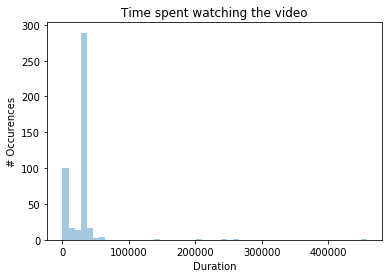

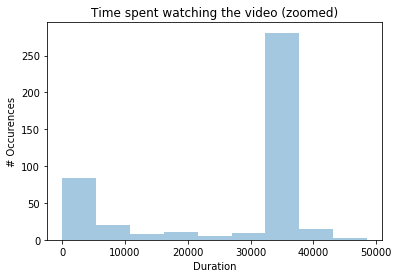

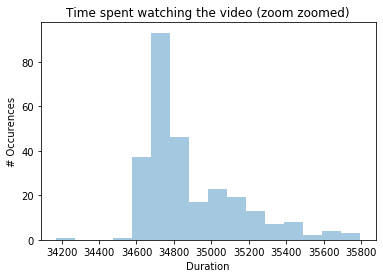

In [15]:
video_watch()

# Make some graphs

In [ ]:
healthcode_map = map_aws_to_healthcode()
#age_activity(healthcode_map)

#page_duration()

most_active = usage_graph(healthcode_map)

journey_map(healthcode_map, most_active)